In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sklearn
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

import argparse
from collections import OrderedDict

import yaml
import csv
import time
from datetime import datetime
import shutil
import logging
from typing import Tuple, Sequence, Any, Union
from functools import partial

from jax import random
import jax.numpy as jnp
import jax
from brax.io import html
from brax import jumpy as jp
from brax import envs
from IPython.display import HTML

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import evojax
from evojax.util import get_params_format_fn
from evojax.task.base import TaskState
from evojax.policy.base import PolicyState
from evojax.policy.base import PolicyNetwork
from flax.struct import dataclass
from flax import linen as nn

from evojax.task.brax_task import BraxTask
from evojax.task.gym_task import Gym
from evojax.algo import PGPE, OpenES
from evojax import ObsNormalizer
from evojax import SimManager

import mediapy as media

sns.set_style('darkgrid')
sns.set_palette('muted', desat=.6)
sns.set_context("notebook", font_scale=1.0,
                rc={"lines.linewidth": 2.5})

output_dir = '/home/floyed/evojax/examples/metaplasticity_plot'

2023-07-11 15:00:08.301868: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
def load_model(model_dir: str, model_name:str = 'best.npz') -> Tuple[np.ndarray, np.ndarray, int, float, int]:
    print(model_dir, model_name)
    model_file = os.path.join(model_dir, model_name)
    if not os.path.exists(model_file):
        model_file = os.path.join(model_dir, 'best.npz')
        # raise ValueError('Model file {} does not exist.')
    with np.load(model_file, allow_pickle=True) as data:
        params = data['params']
        obs_params = data['obs_params']
        epoch = data.get('epoch', 0)
        score = data.get('score', -float('Inf'))
        steps = data.get('steps', 0)
    return params, obs_params, epoch, score, steps

In [4]:
def eval_with_injury(policy, env_name, obs_normalizer, params, obs_params, target=None, injury=False, plot=True, seed=42, injury_ratio=0., ctrl=None):
    # def step_once(carry, input_data):
    #     (task_state, policy_state, params, obs_params,
    #      accumulated_reward) = carry
    #     task_state = task_state.replace(
    #         obs=obs_norm_fn(task_state.obs[None, :], obs_params))
    #     act, policy_state = act_fn(task_state, params[None, :], policy_state)
    #     task_state = task_state.replace(obs=task_state.obs[0])
    #     task_state = env.step(task_state, act[0])
    #     policy_state = update_fn(params[None, :], policy_state, None)
    #     accumulated_reward = accumulated_reward + task_state.reward
    #
    #     return ((task_state, policy_state, params, obs_params, accumulated_reward), (task_state))
    if target is None:
        target = {}
    env_fn = envs.create_fn(
        env_name=env_name,
        legacy_spring=True,
        # max_steps=len(ctrl) if ctrl else 1000
        # terminate_when_unhealthy=args.terminate_when_unhealthy,
        **target
    )
    env = env_fn()
    # state = env.reset(rng=jp.random_prngkey(seed=0))
    task_reset_fn = jax.jit(env.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(env.step)
    act_fn = jax.jit(policy.get_actions)
    # update_fn = jax.jit(policy.update_fn) if hasattr(policy, 'update_fn') else lambda params, p_state, t_state: p_state
    obs_norm_fn = jax.jit(obs_normalizer.normalize_obs)

    total_reward = 0
    rollout = []
    rewards = []
    ws = []
    traces = []
    rng = jax.random.PRNGKey(seed + 1)
    task_state = task_reset_fn(rng=rng)
    policy_state = policy_reset_fn(task_state)
    # print(task_state)
    # accumulated_rewards = jnp.zeros((1, ))
    # task_states = jax.lax.scan(
    #     step_once,
    #     (task_state, policy_state, params, obs_params, accumulated_rewards),
    #     (), 1000
    # )
    # print(task_states)

    step = 0
    while not task_state.done:
    # while step < len(ctrl) if ctrl else 1000:
        if ctrl:
            task_state = task_state.replace(
                obs=task_state.obs.at[-1].set(ctrl[step]))
        task_state = task_state.replace(
            obs=obs_norm_fn(task_state.obs[None, :], obs_params))
        rollout.append(task_state)
        traces.append(policy_state.traces[0])
        # jax.debug.breakpoint()
        act, policy_state = act_fn(task_state, params[None, :], policy_state)
        # For 50 steps, completely zero out the weights to see if the policy can
        # relearn weights that allow the ant to walk.

        if injury_ratio != 0:
            num_zeros = int(injury_ratio * np.prod(policy_state.fast_Ws[1].shape))
            # random_indices = np.random.choice(policy_state.fast_Ws[1].shape[0], num_zeros, replace=False)
            tmp = np.array(policy_state.fast_Ws[1])
            random_indices = np.random.choice(tmp.size, num_zeros, replace=False)
            tmp.flat[random_indices] *= 0
            policy_state.fast_Ws[1] = jnp.array(tmp)

        if step > 500 and step < 550 and injury:
            policy_state.fast_Ws[1] *= 0

        # jax.debug.breakpoint()
        task_state = task_state.replace(obs=task_state.obs[0])
        task_state = step_fn(task_state, act[0])
        # task_state = env.step(task_state, act[0])
        # policy_state = update_fn(params[None, :], policy_state, None)
        total_reward = total_reward + task_state.reward
        rewards.append(task_state.reward)
        # Record the weights every 10 steps for visualisations.
        if hasattr(policy_state, 'fast_Ws') and step % 10 == 0:
            ws.append(policy_state.fast_Ws)
        step += 1

        if step % 100 == 0 and plot:
            print('[Eval with injury] {}, reward:{:.3e}'.format(step, total_reward))
    print('[Eval with injury] rollout reward = {}'.format(total_reward))

    ww = []
    if ws:
        ws = list(zip(*ws))
        for i, w in enumerate(ws):
            w = jnp.concatenate(w)
            # print(w.shape)
            if plot:
                media.show_video(w, height=w.shape[1] * 4, codec='gif', fps=5)
                media.write_video(os.path.join(output_dir, '{}.gif'.format(i)), w, codec='gif', fps=5)
                fig, ax = plt.subplots()
                ax.plot(rewards)
                plt.savefig(os.path.join(output_dir, 'BraxMetaLearning_{}.pdf').format(target))
            ww.append(w)

    return rewards, rollout, ww, traces


def eval_with_injury_base(policy, env_name, obs_normalizer, params, obs_params, target=None, injury=False, plot=True, seed=42, injury_ratio=0., ctrl=None):
    # def step_once(carry, input_data):
    #     (task_state, policy_state, params, obs_params,
    #      accumulated_reward) = carry
    #     task_state = task_state.replace(
    #         obs=obs_norm_fn(task_state.obs[None, :], obs_params))
    #     act, policy_state = act_fn(task_state, params[None, :], policy_state)
    #     task_state = task_state.replace(obs=task_state.obs[0])
    #     task_state = env.step(task_state, act[0])
    #     policy_state = update_fn(params[None, :], policy_state, None)
    #     accumulated_reward = accumulated_reward + task_state.reward
    #
    #     return ((task_state, policy_state, params, obs_params, accumulated_reward), (task_state))
    if target is None:
        target = {}
    env_fn = envs.create_fn(
        env_name=env_name,
        legacy_spring=True,
        # terminate_when_unhealthy=args.terminate_when_unhealthy,
        **target
    )
    env = env_fn()
    # state = env.reset(rng=jp.random_prngkey(seed=0))
    task_reset_fn = jax.jit(env.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(env.step)
    act_fn = jax.jit(policy.get_actions)
    # update_fn = jax.jit(policy.update_fn) if hasattr(policy, 'update_fn') else lambda params, p_state, t_state: p_state
    obs_norm_fn = jax.jit(obs_normalizer.normalize_obs)

    total_reward = 0
    rollout = []
    rewards = []
    ws = []
    traces = []
    rng = jax.random.PRNGKey(seed + 1)
    task_state = task_reset_fn(rng=rng)
    policy_state = policy_reset_fn(task_state)

    # accumulated_rewards = jnp.zeros((1, ))
    # task_states = jax.lax.scan(
    #     step_once,
    #     (task_state, policy_state, params, obs_params, accumulated_rewards),
    #     (), 1000
    # )
    # print(task_states)

    step = 0
    while not task_state.done:
    # while step < len(ctrl) if ctrl else 1000:
        if ctrl:
            task_state = task_state.replace(
                obs=task_state.obs.at[-1].set(ctrl[step]))
        task_state = task_state.replace(
            obs=obs_norm_fn(task_state.obs[None, :], obs_params))
        rollout.append(task_state)
        traces.append(policy_state.variables_tree['mem_status']['LifNeuron_0']['mem'])
        # print(policy_state.variables_tree['mem_status']['LifNeuron_0']['mem'], policy_state.variables_tree['mem_status']['LifNeuron_0']['mem'].shape)
        # jax.debug.breakpoint()
        act, policy_state = act_fn(task_state, params[None, :], policy_state)
        # For 50 steps, completely zero out the weights to see if the policy can
        # relearn weights that allow the ant to walk.
        if injury_ratio != 0:
            num_zeros = int(injury_ratio * params.shape[0])
            random_indices = np.random.choice(params.shape[0], num_zeros, replace=False)
            params[random_indices] *= 0

        if step > 500 and step < 550 and injury:
            params *= 0
            # policy_state.fast_Ws[1] *= 0

        # jax.debug.breakpoint()
        task_state = task_state.replace(obs=task_state.obs[0])
        task_state = step_fn(task_state, act)
        # task_state = env.step(task_state, act[0])
        # policy_state = update_fn(params[None, :], policy_state, None)
        total_reward = total_reward + task_state.reward
        rewards.append(task_state.reward)
        # Record the weights every 10 steps for visualisations.
        if hasattr(policy_state, 'fast_Ws') and step % 10 == 0:
            ws.append(policy_state.fast_Ws)
        step += 1

        if step % 100 == 0 and plot:
            print('[Eval with injury] {}, reward:{:.3e}'.format(step, total_reward))
    print('[Eval with injury] rollout reward = {}'.format(total_reward))

    if plot:
        ws = list(zip(*ws))
        for i, w in enumerate(ws):
            w = np.array(jnp.concatenate(w)[jnp.newaxis, :, jnp.newaxis, :, :])
            # TODO: w

        html.save_html(os.path.join(output_dir, 'eval_with_injury_{}.html'.format(target)), env.sys, [s.qp for s in rollout])

        fig, ax = plt.subplots()
        ax.plot(rewards)
        plt.savefig(os.path.join(output_dir, 'BraxMetaLearning_{}.pdf').format(target))

    return rewards, rollout, traces

In [5]:
env = 'ant_dir'
num_tasks = 8
num_tasks = 8
hidden_dims = [128]
# resume_meta = '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230622-192211'
# resume_base = '/data/floyed/meta/train/PGPE-MLPSnnPolicy-ant_dir--20230622-113608'

resume_meta = [
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230622-192211',
    # '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-swimmer_dir-ABCD-20230622-192221',
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-swimmer_dir-ABCD-20230624-095727',
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-halfcheetah_vel-ABCD-20230622-192203',
    '/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-hopper_vel-ABCD-20230622-192225',
]

resume_base = [
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-ant_dir--20230622-113608',
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-swimmer_dir--20230622-113637',
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-halfcheetah_vel--20230622-113532',
    '/data/floyed/meta/train/PGPE-MLPSnnPolicy-hopper_vel--20230622-113649',
]
env_names = ['ant_dir',  'swimmer_dir', 'halfcheetah_vel', 'hopper_vel']

In [6]:
env_traces_base, env_traces_meta = [], []

for idx, env in enumerate(env_names):
    train_task = BraxTask(
        env_name=env,
        test=False,
        num_tasks=num_tasks
        # terminate_when_unhealthy=args.terminate_when_unhealthy
    )
    policy_meta = getattr(evojax.policy, 'MetaStdpMLPPolicy')(
        input_dim=train_task.obs_shape[0],
        hidden_dims=[
            *hidden_dims,
        ],
        output_dim=train_task.act_shape[0],
    )

    policy_base = getattr(evojax.policy, 'MLPSnnPolicy')(
        input_dim=train_task.obs_shape[0],
        hidden_dims=[
            *hidden_dims,
        ],
        output_dim=train_task.act_shape[0],
    )

    meta_best_params, meta_obs_params, meta_epoch, meta_best_score, meta_steps = load_model(model_dir=resume_meta[idx])
    base_best_params, base_obs_params, base_epoch, base_best_score, base_steps = load_model(model_dir=resume_base[idx], model_name='iter_1490.npz')
    meta_obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)
    base_obs_normalizer = ObsNormalizer(obs_shape=train_task.obs_shape, task_info_holder=train_task.task_info_holder)

    x, y_meta, y_base, traces_meta, traces_base = [], [], [], [], []
    for i in range(8):
        print('{} / 8'.format(i))
        _min = train_task.task_min + (train_task.task_max - train_task.task_min) / 8
        _max = train_task.task_max - (train_task.task_max - train_task.task_min) / 8
        target = (1 - i / 8) * train_task.task_min + i / 8 * train_task.task_max
        _target = (1 - i / 8) * _min + i / 8 * _max
        meta_rewards, meta_rollout, ws, trace_meta = \
            eval_with_injury(policy_meta, env, meta_obs_normalizer, meta_best_params, meta_obs_params, target={train_task.task_kwargs: _target}, injury=False, plot=False, seed=41)
        base_rewards, base_rollout, trace_base = \
            eval_with_injury_base(policy_base, env, base_obs_normalizer, base_best_params, base_obs_params, target={train_task.task_kwargs: _target}, injury=False, plot=False, seed=41)
        x.append(target)
        # y_meta.append(sum(meta_rewards))
        # y_base.append(sum(base_rewards))
        traces_meta.append(trace_meta)
        traces_base.append(trace_base)
    env_traces_base.append(traces_base)
    env_traces_meta.append(traces_meta)

(28,) (8,)


MLPPolicy: 2023-07-11 15:00:13,308 [INFO] MLPPolicy.num_params = 4744


/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-ant_dir-ABCD-20230622-192211 best.npz
/data/floyed/meta/train/PGPE-MLPSnnPolicy-ant_dir--20230622-113608 iter_1490.npz
(28,)
(28,)
0 / 8
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5339.15966796875
(1, 1) (1, 27)
[Eval with injury] rollout reward = 998.62060546875
1 / 8
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5358.8173828125
(1, 1) (1, 27)
[Eval with injury] rollout reward = 1003.3582153320312
2 / 8
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5434.1767578125
(1, 1) (1, 27)
[Eval with injury] rollout reward = 1006.7227783203125
3 / 8
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5440.6845703125
(1, 1) (1, 27)
[Eval with injury] rollout reward = 1005.2191162109375
4 / 8
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5410.72265625
(1, 1) (1, 27)
[Eval with injury] rollout reward = 999.8939208984375
5 / 8
(1, 1) (1, 27)
[Eval with injury] rollout reward = 5416.64306640625
(1, 1) (1, 27)
[Eval with injury] roll

MLPPolicy: 2023-07-11 15:02:32,032 [INFO] MLPPolicy.num_params = 1538


/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-swimmer_dir-ABCD-20230624-095727 best.npz
/data/floyed/meta/train/PGPE-MLPSnnPolicy-swimmer_dir--20230622-113637 iter_1490.npz
(9,)
(9,)
0 / 8
(1, 1) (1, 8)
[Eval with injury] rollout reward = 7426.88671875
(1, 1) (1, 8)
[Eval with injury] rollout reward = 43.20600128173828
1 / 8
(1, 1) (1, 8)
[Eval with injury] rollout reward = 13255.447265625
(1, 1) (1, 8)
[Eval with injury] rollout reward = 3.2240090370178223
2 / 8
(1, 1) (1, 8)
[Eval with injury] rollout reward = 17661.298828125
(1, 1) (1, 8)
[Eval with injury] rollout reward = 37.8825798034668
3 / 8
(1, 1) (1, 8)
[Eval with injury] rollout reward = 18580.86328125
(1, 1) (1, 8)
[Eval with injury] rollout reward = 35.718658447265625
4 / 8
(1, 1) (1, 8)
[Eval with injury] rollout reward = 18137.94140625
(1, 1) (1, 8)
[Eval with injury] rollout reward = 19.519027709960938
5 / 8
(1, 1) (1, 8)
[Eval with injury] rollout reward = 17135.796875
(1, 1) (1, 8)
[Eval with injury] rollout reward =

MLPPolicy: 2023-07-11 15:03:50,293 [INFO] MLPPolicy.num_params = 3334


/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-halfcheetah_vel-ABCD-20230622-192203 best.npz
/data/floyed/meta/train/PGPE-MLPSnnPolicy-halfcheetah_vel--20230622-113532 iter_1490.npz
(19,)
(19,)
0 / 8
(1, 1) (1, 18)
[Eval with injury] rollout reward = -206.9838409423828
(1, 1) (1, 18)
[Eval with injury] rollout reward = -265.251708984375
1 / 8
(1, 1) (1, 18)
[Eval with injury] rollout reward = -314.32427978515625
(1, 1) (1, 18)
[Eval with injury] rollout reward = -477.2335205078125
2 / 8
(1, 1) (1, 18)
[Eval with injury] rollout reward = -406.2018737792969
(1, 1) (1, 18)
[Eval with injury] rollout reward = -784.2899169921875
3 / 8
(1, 1) (1, 18)
[Eval with injury] rollout reward = -475.7767028808594
(1, 1) (1, 18)
[Eval with injury] rollout reward = -1533.2886962890625
4 / 8
(1, 1) (1, 18)
[Eval with injury] rollout reward = -588.2975463867188
(1, 1) (1, 18)
[Eval with injury] rollout reward = -2401.15576171875
5 / 8
(1, 1) (1, 18)
[Eval with injury] rollout reward = -716.2826538085938


MLPPolicy: 2023-07-11 15:06:10,104 [INFO] MLPPolicy.num_params = 2051


/data/floyed/meta/train/PGPE-MetaStdpMLPPolicy-hopper_vel-ABCD-20230622-192225 best.npz
/data/floyed/meta/train/PGPE-MLPSnnPolicy-hopper_vel--20230622-113649 iter_1490.npz
(12,)
(12,)
0 / 8
(1, 1) (1, 11)
[Eval with injury] rollout reward = 971.272705078125
(1, 1) (1, 11)
[Eval with injury] rollout reward = 914.9967041015625
1 / 8
(1, 1) (1, 11)
[Eval with injury] rollout reward = 964.2227172851562
(1, 1) (1, 11)
[Eval with injury] rollout reward = 889.676513671875
2 / 8
(1, 1) (1, 11)
[Eval with injury] rollout reward = 945.895751953125
(1, 1) (1, 11)
[Eval with injury] rollout reward = 860.4217529296875
3 / 8
(1, 1) (1, 11)
[Eval with injury] rollout reward = 952.5214233398438
(1, 1) (1, 11)
[Eval with injury] rollout reward = 857.1778564453125
4 / 8
(1, 1) (1, 11)
[Eval with injury] rollout reward = 938.00830078125
(1, 1) (1, 11)
[Eval with injury] rollout reward = 827.2636108398438
5 / 8
(1, 1) (1, 11)
[Eval with injury] rollout reward = 922.20166015625
(1, 1) (1, 11)
[Eval with in

In [10]:
RS = 20150104
num_classes = 8

metas, bases = [], []
# fig = plt.figure(figsize=(18, 2.75), dpi=100, constrained_layout=True)
# spec = fig.add_gridspec(nrows=1, ncols=12, figure=fig, width_ratios=[1, 1, .1, 1, 1, .1, 1, 1, .1, 1, 1, .1,])  # , width_ratios=[1, 1], height_ratios=[1, 1]
for rs in range(RS, RS + 1):
    for idx, env in enumerate(env_names):
        print(env)
        traces_meta, traces_base = env_traces_meta[idx], env_traces_base[idx]
        meta = np.array(traces_meta).squeeze()[:, 100:800, :]  # dir, step, dim
        base = np.array(traces_base).squeeze()[:, 100:800, :]
        meta = meta.reshape(-1, 128)
        base = base.reshape(-1, 128)

        # label = []
        # for i in range(8):
        #     label.append(i * np.ones(700))
        # label = np.array(label).reshape(-1)

        _meta = TSNE(random_state=rs, n_components=2).fit_transform(meta)
        _base = TSNE(random_state=rs, n_components=2).fit_transform(base)
        # palette = np.array(sns.color_palette("hls", num_classes))
        metas.append(_meta)
        bases.append(_base)
        # sns.despine()
        # sns.set_style("ticks")
        # ax = fig.add_subplot(spec[0, idx * 3])
        # sc = ax.scatter(_meta[:, 0], _meta[:, 1], lw=0, s=25, c=palette[label.astype(int)])
        # plt.xticks([-50, 0, 50])
        # plt.yticks([-50, 0, 50])

        # sns.despine()
        # sns.set_style("ticks")
        # ax = fig.add_subplot(spec[0, idx * 3 + 1])
        # sc = ax.scatter(_base[:, 0], _base[:, 1], lw=0, s=25, c=palette[label.astype(int)])
        # sns.despine()
        # plt.xticks([-50, 0, 50])
        # plt.yticks([-50, 0, 50])


        # train_task = BraxTask(
        #     env_name=env,
        #     test=False,
        #     num_tasks=num_tasks
        #     # terminate_when_unhealthy=args.terminate_when_unhealthy
        # )
        # sns.set_style("ticks")
        # ax = fig.add_subplot(spec[0, idx * 3 + 2])
        # cax = fig.colorbar(sc, cax=ax)
        # ticks, ticks_labels = [], []
        # for i in range(8):
        #     ticks.append(i)
        #     tl = train_task.task_min + i / 8 * (train_task.task_max - train_task.task_min)
        #     if 'dir' in env:
        #         ticks_labels.append(tl / np.pi * 180)
        #     else:
        #         ticks_labels.append(tl)
        # cax.set_ticks(ticks)
        # cax.set_ticklabels(ticks_labels)
        # ax.set_label('$\Delta w$')

    # plt.savefig(os.path.join(output_dir, 'rl_tsne.pdf').format(env, rs))
    # plt.show()

ant_dir


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


swimmer_dir


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


halfcheetah_vel


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


hopper_vel


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 1800x275 with 0 Axes>

ant_dir
(28,) (8,)
swimmer_dir
(9,) (2,)
halfcheetah_vel
(19,) (6,)
hopper_vel
(12,) (3,)


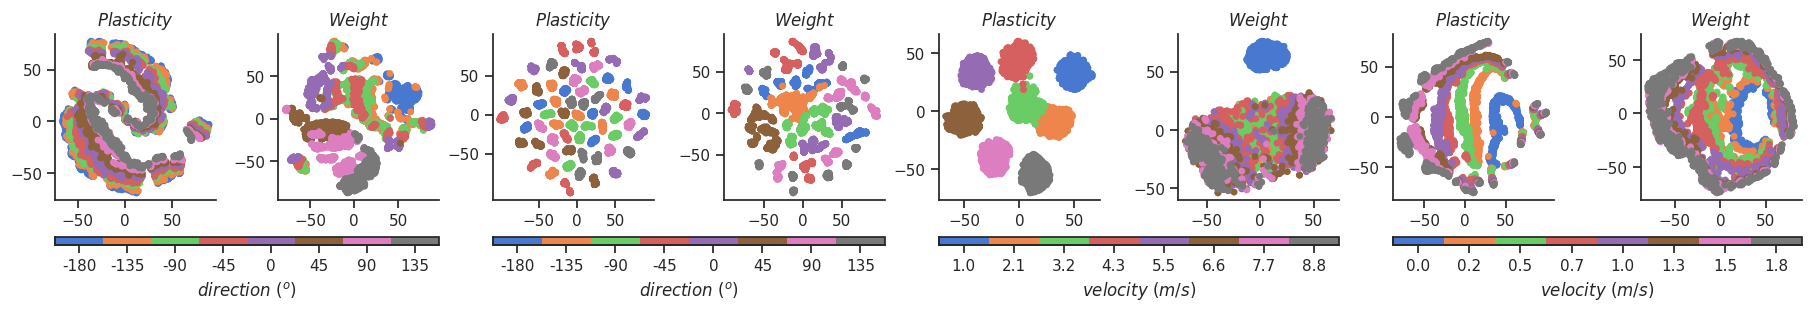

In [55]:
fig = plt.figure(figsize=(18, 3), dpi=100, constrained_layout=True)
spec = fig.add_gridspec(nrows=2, ncols=8, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1, 1, 1], height_ratios=[1, .05])  # , width_ratios=[1, 1], height_ratios=[1, 1]

label = []
for i in range(8):
    label.append(i * np.ones(700))
label = np.array(label).reshape(-1)
palette = np.array(sns.color_palette("muted", num_classes))
import matplotlib
cmap = matplotlib.colors.ListedColormap(np.array(palette))

for rs in range(RS, RS + 1):
    for idx, env in enumerate(env_names):
        print(env)
        # traces_meta, traces_base = env_traces_meta[idx], env_traces_base[idx]
        # meta = np.array(traces_meta).squeeze()[:, 100:800, :]  # dir, step, dim
        # base = np.array(traces_base).squeeze()[:, 100:800, :]
        # meta = meta.reshape(-1, 128)
        # base = base.reshape(-1, 128)
        #
        #
        # _meta = TSNE(random_state=rs, n_components=2).fit_transform(meta)
        # _base = TSNE(random_state=rs, n_components=2).fit_transform(base)

        _meta, _base = metas[idx], bases[idx]
        # sns.despine()
        sns.set_style("ticks")
        ax = fig.add_subplot(spec[0, idx * 2])
        sc = ax.scatter(_meta[:, 0], _meta[:, 1], lw=0, s=25, c=palette[label.astype(int)])
        plt.xticks([-50, 0, 50])
        plt.yticks([-50, 0, 50])
        ax.set_title('$Plasticity$')

        # sns.despine()
        sns.set_style("ticks")
        ax = fig.add_subplot(spec[0, idx * 2 + 1])
        sc = ax.scatter(_base[:, 0], _base[:, 1], lw=0, s=25, c=palette[label.astype(int)])
        sns.despine()
        plt.xticks([-50, 0, 50])
        plt.yticks([-50, 0, 50])
        ax.set_title('$Weight$')

        train_task = BraxTask(
            env_name=env,
            test=False,
            num_tasks=num_tasks
            # terminate_when_unhealthy=args.terminate_when_unhealthy
        )
        sns.set_style("ticks")
        ax = fig.add_subplot(spec[1, idx * 2: idx * 2 + 2])
        psm = ax.pcolormesh(np.random.rand(1, 50), cmap=cmap, rasterized=True, vmin=0, vmax=1)
        cax = fig.colorbar(psm, cax=ax, orientation="horizontal")
        # cax = fig.colorbar(sc, cax=ax, orientation="horizontal")
        ticks, ticks_labels = [], []
        title = '$velocity$ $(m/s)$' if 'vel' in env else '$direction$ $(^o)$'
        for i in range(8):
            ticks.append(i / 8 + 1 / 16)
            tl = train_task.task_min + i / 8 * (train_task.task_max - train_task.task_min)
            if 'dir' in env:
                tl = int(tl / np.pi * 180)
            else:
                tl = int(tl * 10) / 10
            ticks_labels.append(tl)
        cax.set_ticks(ticks)
        cax.set_ticklabels(ticks_labels)
        cax.set_label(title)
        sns.despine()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.savefig(os.path.join(output_dir, 'rl_tsne.pdf').format(env, rs))
    plt.show()

In [ ]:
# RS = 20150101
# num_classes = 8
#
# meta = np.array(metas).squeeze().transpose(1, 0, 2, 3)  # dir, seed, step, dim
# base = np.array(bases).squeeze().transpose(1, 0, 2, 3)
#
# meta = meta.reshape(-1, 128 * 1000)
# base = base.reshape(-1, 128 * 1000)
#
# label = []
# for i in range(8):
#     label.append(i * np.ones(5))
# label = np.array(label).reshape(-1)
#
# meta = TSNE(random_state=RS, n_components=2).fit_transform(meta)
# base = TSNE(random_state=RS, n_components=2).fit_transform(base)
# palette = np.array(sns.color_palette("hls", num_classes))
#
# fig = plt.figure(figsize=(18, 6), dpi=100, constrained_layout=True)
# spec = fig.add_gridspec(nrows=1, ncols=2, figure=fig)  # , width_ratios=[1, 1], height_ratios=[1, 1]
#
# ax = fig.add_subplot(spec[0, 0])
# sc = ax.scatter(meta[:, 0], meta[:, 1], lw=0, s=25, c=palette[label.astype(np.int)])
#
# ax = fig.add_subplot(spec[0, 1])
# sc = ax.scatter(base[:, 0], base[:, 1], lw=0, s=25, c=palette[label.astype(np.int)])